# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 94402501.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8643905.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26009663.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18622217.76it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


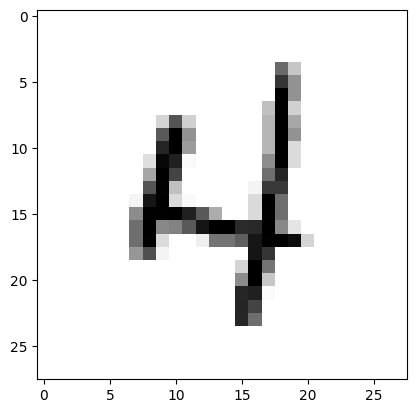

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

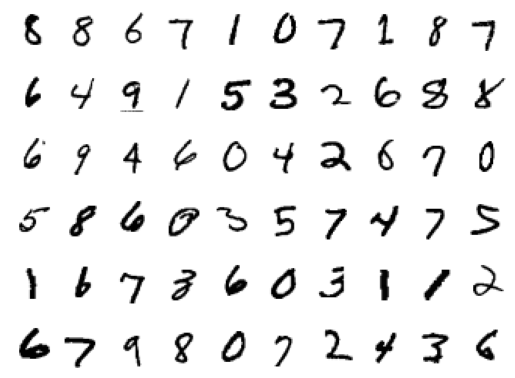

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model


In [ ]:
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(4), nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value), nn.ReLU()
        ) # output_size = 7
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1, 1))



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
# Model Summary
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
           Dropout-3            [-1, 4, 26, 26]               0
              ReLU-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             288
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             720
      BatchNorm2d-10           [-1, 10, 22, 22]              20
          Dropout-11           [-1, 10, 22, 22]               0
             ReLU-12           [-1, 10, 22, 22]               0

# Training and Testing


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch+1)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.7770065665245056 Batch_id=468 Accuracy=64.95: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]



Test set: Average loss: 0.7153, Accuracy: 8424/10000 (84.24%)

EPOCH: 2


Loss=0.3333602845668793 Batch_id=468 Accuracy=90.32: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.3826, Accuracy: 9016/10000 (90.16%)

EPOCH: 3


Loss=0.2674778401851654 Batch_id=468 Accuracy=93.03: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]



Test set: Average loss: 0.3364, Accuracy: 9116/10000 (91.16%)

EPOCH: 4


Loss=0.17464685440063477 Batch_id=468 Accuracy=94.07: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.2932, Accuracy: 9196/10000 (91.96%)

EPOCH: 5


Loss=0.17009806632995605 Batch_id=468 Accuracy=94.79: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.2557, Accuracy: 9296/10000 (92.96%)

EPOCH: 6


Loss=0.19136865437030792 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.1901, Accuracy: 9525/10000 (95.25%)

EPOCH: 7


Loss=0.25431355834007263 Batch_id=468 Accuracy=95.46: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.2763, Accuracy: 9208/10000 (92.08%)

EPOCH: 8


Loss=0.15283317863941193 Batch_id=468 Accuracy=95.59: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.1651, Accuracy: 9555/10000 (95.55%)

EPOCH: 9


Loss=0.14121384918689728 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.1324, Accuracy: 9655/10000 (96.55%)

EPOCH: 10


Loss=0.1071891188621521 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.1876, Accuracy: 9465/10000 (94.65%)

EPOCH: 11


Loss=0.2702961266040802 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.1632, Accuracy: 9573/10000 (95.73%)

EPOCH: 12


Loss=0.13315258920192719 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.2468, Accuracy: 9307/10000 (93.07%)

EPOCH: 13


Loss=0.18807131052017212 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.1586, Accuracy: 9566/10000 (95.66%)

EPOCH: 14


Loss=0.12848226726055145 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.1888, Accuracy: 9468/10000 (94.68%)

EPOCH: 15


Loss=0.24918000400066376 Batch_id=468 Accuracy=96.24: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]



Test set: Average loss: 0.1758, Accuracy: 9488/10000 (94.88%)



Text(0.5, 1.0, 'Test Accuracy')

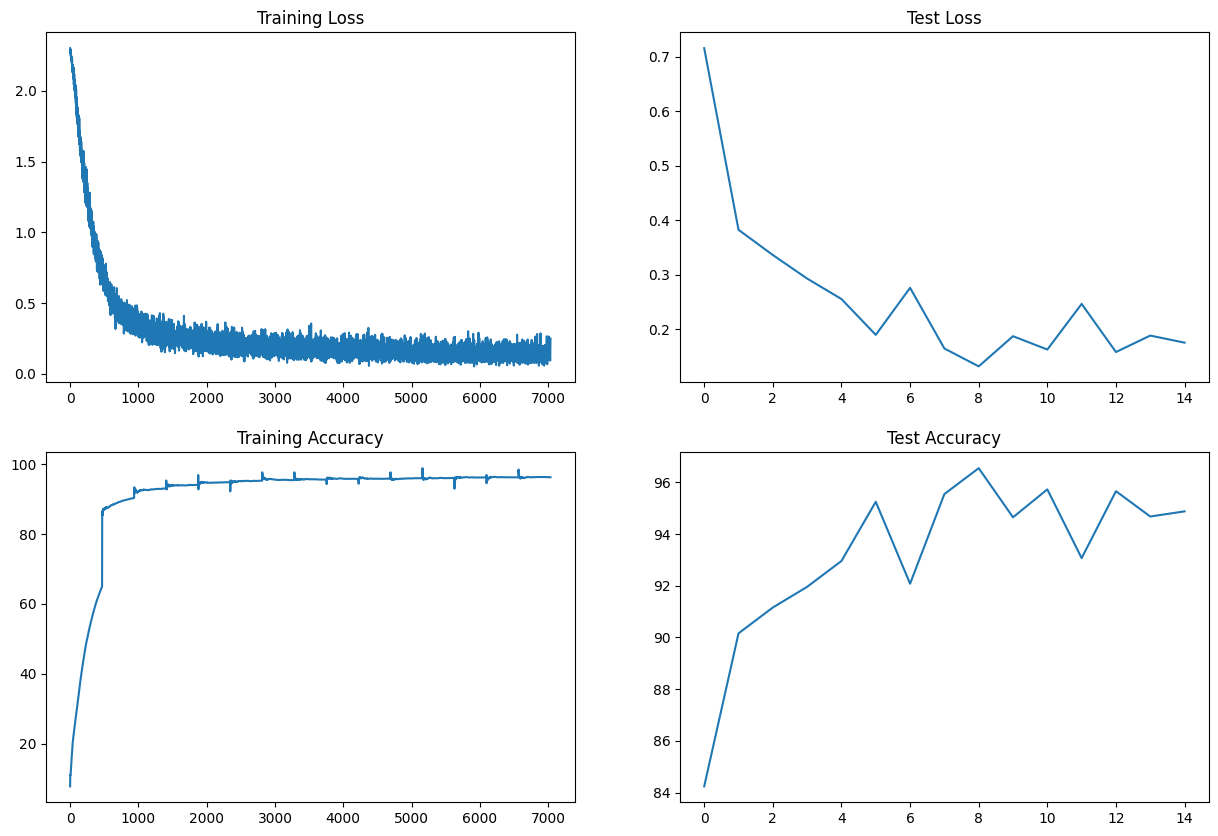

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")